# Process Gene Expression from DataDescriptor
This notebook will prepare gene expression information from [Nature Scientific Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5903355/pdf/sdata201861.pdf).
The data is already quantified (FPKM) and contains normal and tumor tissue samples from TCGA as well as normal tissue from GTEX.
I will only use the GTEX and TCGA tumor data to compute _log2 fold changes_ of the two. I will then remove genes that are not in our PPI network and feed the fold changes as features into a hhdf5 container.

In [1]:
import pandas as pd
import numpy as np
import os, sys, h5py
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Step 1: Loading data for tissues and computing log2 fold changes
The data can be loaded from the gzipped files directly. The fold changes can be computed as:
\begin{equation*}
FC_c = \log_2\big(\frac{P_c}{mean(N_t)}\big)
\end{equation*}
where $P_c \in \mathbb{R}^{n \times m}$ is the patient-wise matrix containing the FPKM-normalized read counts for $n$ patients (columns) and $m$ genes (rows) for a cancer type $c$. $N_t$ is the gtex normal tissue matrix for a tissue $t$ that corresponds to the cancer type $c$.

For the normal data, we first compute the mean over all samples and then divide that by the FPKM counts for each patient in $P_c$. Only after that, we compute the mean across the patients.

In [2]:
# function to get the fold changes
def compute_geneexpression_foldchange(tumor_path, normal_path):
    # read tumor and normal data
    tumor_ge = pd.read_csv(tumor_path, compression='gzip', sep='\t').set_index('Hugo_Symbol').drop('Entrez_Gene_Id', axis=1)
    normal_ge = pd.read_csv(normal_path, compression='gzip', sep='\t').set_index('Hugo_Symbol').drop('Entrez_Gene_Id', axis=1)
    assert (np.all(tumor_ge.index == normal_ge.index))

    # compute log2 fold changes (for each patient, divide by mean gtex expression. Then compute mean across patients)
    fc = np.log2(tumor_ge.divide(normal_ge.mean(axis=1), axis=0))
    fc = fc.replace([np.inf, -np.inf], np.nan).dropna(axis=0) # remove NaN and inf (from division by 0 or 0+eta)
    return fc.mean(axis=1), tumor_ge, normal_ge

In [3]:
# get the file names ready
dir_name = '../../data/pancancer/TCGA/expression/tcga_expr_datadescriptor_normalized_batchcorr/'
tumor_path = os.path.join(dir_name, '{}-rsem-fpkm-tcga-t.txt.gz')
gtex_path = os.path.join(dir_name, '{}-rsem-fpkm-gtex.txt.gz')

# now, apply that function for all TCGA-project and tissue pairs
tissue_pairs = [('bladder', 'blca'), ('breast', 'brca'), ('cervix', 'cesc'),
                ('uterus', 'ucec'), ('colon', 'read'),
                ('colon', 'coad'), ('liver', 'lihc'), ('salivary', 'hnsc'),
                ('esophagus_mus', 'esca'), ('prostate', 'prad'), ('stomach', 'stad'),
                ('thyroid', 'thca'), ('lung', 'luad'), ('lung', 'lusc'),
                ('kidney', 'kirc'), ('kidney', 'kirp')]

log_fold_changes = []
tumor_fpkm = []
gtex_fpkm = []
for gtex_tissue, tcga_project in tissue_pairs:
    fc, tumor, normal = compute_geneexpression_foldchange(tumor_path=tumor_path.format(tcga_project), normal_path=gtex_path.format(gtex_tissue))
    log_fold_changes.append(fc)
    tumor_fpkm.append(tumor)
    gtex_fpkm.append(normal)

# convert everything to one big DataFrame
all_foldchanges = pd.DataFrame(log_fold_changes, index=[i[1] for i in tissue_pairs]).T
all_foldchanges.head()

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log2


,blca,brca,cesc,ucec,read,coad,lihc,hnsc,esca,prad,stad,thca,luad,lusc,kirc,kirp
A1BG,-0.608508,0.775810,-3.521485,-1.703102,-1.688058,-1.696607,-3.252436,0.345618,0.570655,-2.183498,-1.434350,0.593572,NaN,-0.635748,-0.451117,-0.430529
A1CF,NaN,NaN,NaN,NaN,-2.613041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,-3.028350,-1.718834,-2.655475,-2.400874,-1.384690,-1.649269,-2.179860,-0.576464,-1.566152,-0.438804,-0.414274,0.296752,-2.88369,-4.151072,-0.056761,-2.125183
A4GALT,-1.355647,-0.900167,-0.878630,-0.972807,-0.993766,-1.143416,0.244438,-0.384425,-1.054090,-1.024385,-1.223291,-0.080504,NaN,0.366121,0.165375,0.332916
AAAS,0.194814,-0.105037,0.102720,-0.015798,0.311405,0.363950,0.487518,0.113281,-0.121364,0.244647,0.139916,-0.200979,NaN,0.413073,0.091837,0.428861


In [5]:
all_foldchanges[all_foldchanges.index == 'BRCA2']

,blca,brca,cesc,ucec,read,coad,lihc,hnsc,esca,prad,stad,thca,luad,lusc,kirc,kirp
BRCA2,1.766988,0.905673,2.445681,2.022815,1.829137,1.62,0.663048,0.988208,2.876013,NaN,1.848209,0.323634,NaN,1.012893,NaN,0.132447


## Step 2: Verify correct data by plots

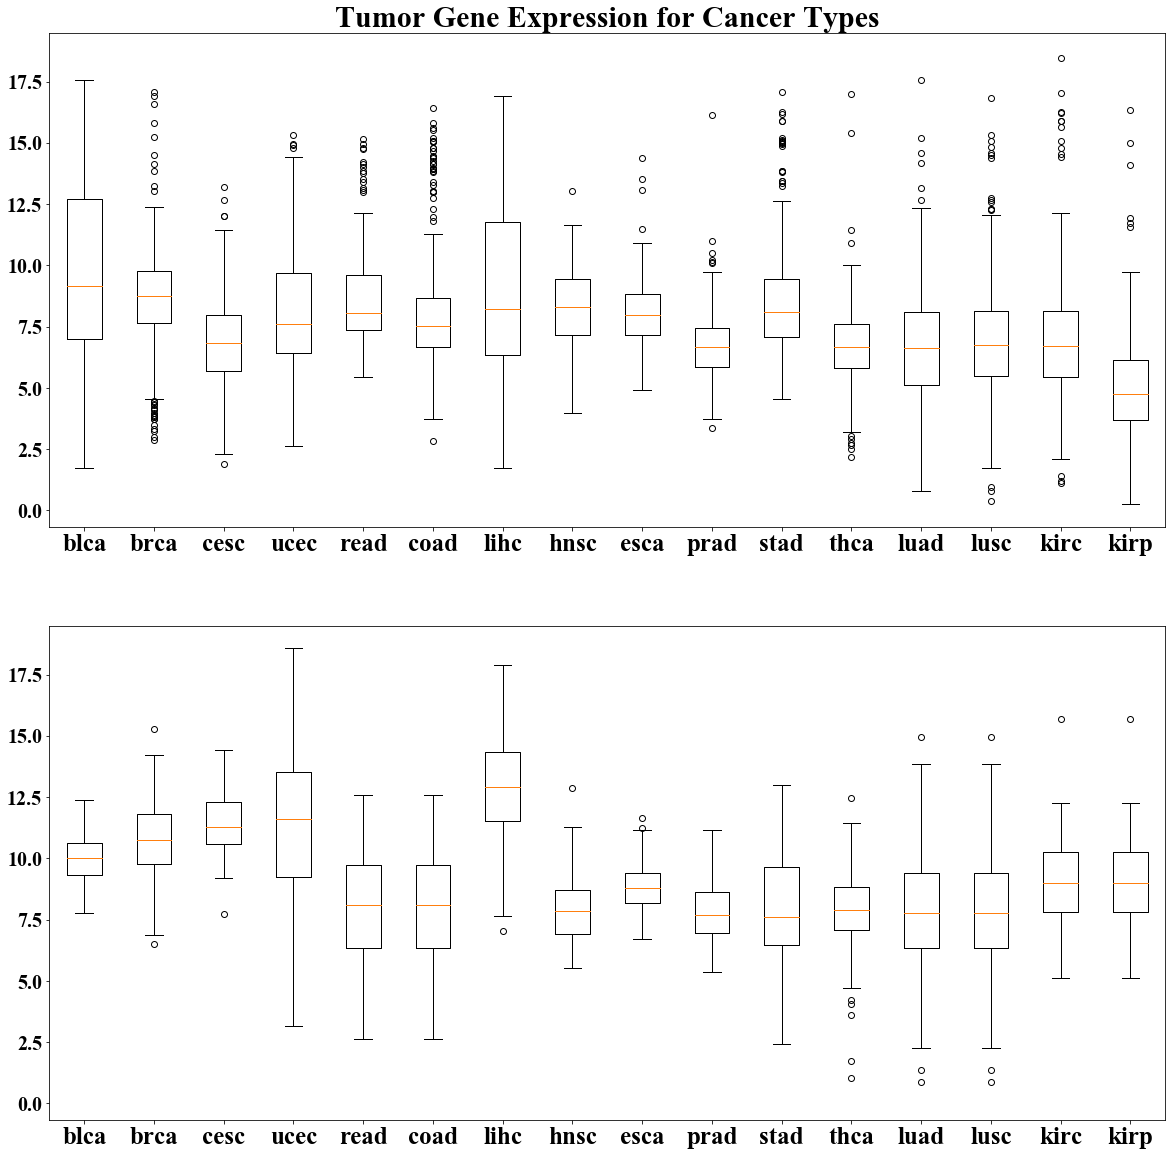

In [5]:
# reproduce the plots from data descriptor paper
gene_of_interest = 'IGF2'
tumor_for_gene_all = []
for matrix in tumor_fpkm:
    l = np.log2(matrix[matrix.index == gene_of_interest].T.values).flatten().tolist()
    tumor_for_gene_all.append(l)

gtex_for_gene_all = []
for matrix in gtex_fpkm:
    l = np.log2(matrix[matrix.index == gene_of_interest].T.values).flatten().tolist()
    gtex_for_gene_all.append(l)

fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(2, 1, 1)
_ = plt.boxplot(tumor_for_gene_all)
_ = plt.gca().set_xticklabels(all_foldchanges.columns, fontsize=25)
plt.gca().tick_params(axis='y', which='major', labelsize=20)
plt.title('Tumor Gene Expression for Cancer Types', fontsize=30)

plt.subplot(2, 1, 2, sharex=ax, sharey=ax)
_ = plt.boxplot(gtex_for_gene_all)
_ = plt.gca().set_xticklabels(all_foldchanges.columns, fontsize=25)
plt.gca().tick_params(axis='y', which='major', labelsize=20)

(-2, 2)

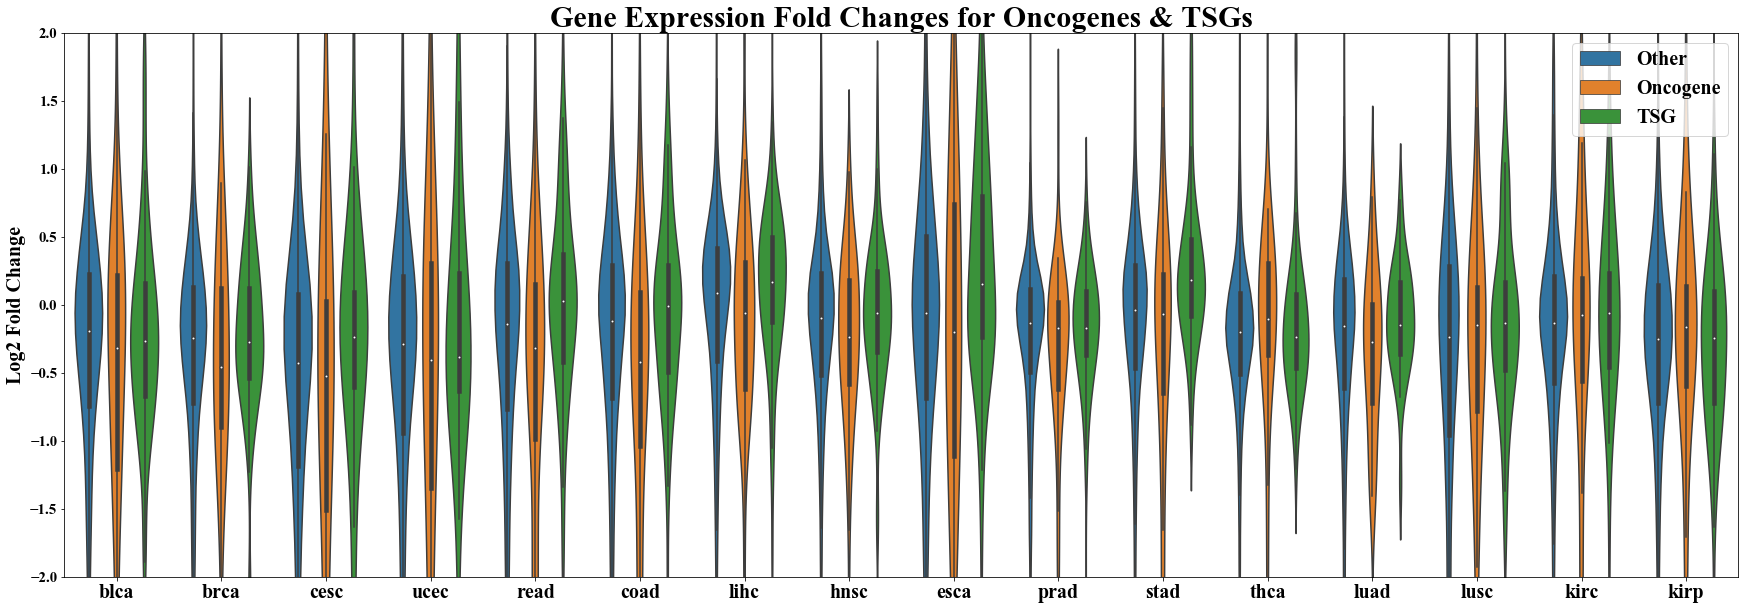

In [6]:
onco_tsgs = pd.read_csv('../../data/pancancer/vogelstein/table_s2a.csv', sep='\t')
onco_tsgs.set_index('Gene Symbol', inplace=True)
all_foldchanges['Gene_Type'] = 'Other'
all_foldchanges.loc[all_foldchanges.index.isin(onco_tsgs[onco_tsgs['Classification*'] == 'TSG'].index), 'Gene_Type'] = 'TSG'
all_foldchanges.loc[all_foldchanges.index.isin(onco_tsgs[onco_tsgs['Classification*'] == 'Oncogene'].index), 'Gene_Type'] = 'Oncogene'
all_foldchanges.Gene_Type.value_counts()


fig = plt.figure(figsize=(30, 10))
ax = sns.violinplot(data=pd.melt(all_foldchanges, id_vars='Gene_Type'), x='variable', y='value', hue='Gene_Type')

plt.xlabel('')
plt.ylabel('Log2 Fold Change', fontsize=20)
plt.title('Gene Expression Fold Changes for Oncogenes & TSGs', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.legend(loc='upper right', fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.ylim([-2, 2])

In [7]:
all_foldchanges[all_foldchanges.index == 'KRAS']

,blca,brca,cesc,ucec,read,coad,lihc,hnsc,esca,prad,stad,thca,luad,lusc,kirc,kirp,Gene_Type
KRAS,-0.279526,0.392243,0.147013,0.412589,-0.686423,-0.874579,-0.289891,-0.231928,0.016543,-0.027088,0.080184,-0.213547,NaN,0.199556,-0.238544,-0.308927,Oncogene


## Step 3: Remove Genes that are not in our network & create container

In [8]:
with h5py.File('../../data/pancancer/hotnet_iref_vec_input_unbalanced.h5', 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [9]:
# remove genes that are not in the network
features_ge = all_foldchanges[all_foldchanges.index.isin(node_names[:, 1])]
print ("Dropped {} genes that are not in network (Before: {}\tNow: {})".format(all_foldchanges.shape[0] - features_ge.shape[0], all_foldchanges.shape[0], features_ge.shape[0]))

# reindex (introduces all nodes to the features and makes sure, the order of node names is the same as the order of features)
F = features_ge.reindex(node_names[:, 1])

# replace NaNs with 0
no_of_nan_elems = F.isnull().sum().sum()
F = F.replace(np.nan, 0)
print ("Replaced {} NaN values in gene expression with 0 (out of {})".format(no_of_nan_elems, np.prod(F.shape)))

Dropped 4875 genes that are not in network (Before: 15304	Now: 10429)
Replaced 51526 NaN values in gene expression with 0 (out of 206193)


In [14]:
# write back to container
F.drop('Gene_Type', axis=1, errors='ignore', inplace=True)

features = F.as_matrix()
feature_names = np.array(F.columns)
string_dt = h5py.special_dtype(vlen=str)

assert ((F.index == node_names[:, 1]).all())

fname = '../../data/pancancer/iref_TCGA_expression_log2fc_gtexnorm.h5'
f = h5py.File(fname, 'w')

# add ppi network
f.create_dataset('network', data=network, shape=network.shape)

# add features
f.create_dataset('features', data=features, shape=features.shape)

# add gene names (same order as features & network)
f.create_dataset('gene_names', data=node_names, dtype=string_dt)
# add labels
f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
if y_val is not None:
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)

f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
if y_val is not None:
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.create_dataset('feature_names', data=feature_names, dtype=string_dt)

f.close()
print ("Container written to {}".format(fname))

Container written to ../../data/pancancer/iref_TCGA_expression_log2fc_gtexnorm.h5


## Step 4: T-SNE plot of features